In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

warnings.filterwarnings('ignore')  # ignore all warnings
# warnings.filterwarnings(action='once')  # see warning once, then ignore

sys.setrecursionlimit(10000)

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)

# ECE Plotting function

In [39]:
from sklearn.isotonic import IsotonicRegression


def log2(x):
    return np.log(x) / np.log(2)


# def log_lr_cost(lr, score_col):    
#     lr_same = np.exp(np.array(lr[score_col].loc[lr.a == lr.b], 
#                               dtype=np.float128))
#     lr_diff = np.exp(np.array(lr[score_col].loc[lr.a != lr.b], 
#                               dtype=np.float128))
#     return (2*len(lr_same))**-1 * np.sum(log2(1 + 1/(lr_same))) + \
#            (2*len(lr_diff))**-1 * np.sum(log2(1 + lr_diff))
# 
# print(round(log_lr_cost(oc_lr, 'lr_alpha_vary'),3))


def log_lr_cost(lr_same, lr_diff, neutral=False): 
    if neutral:
        lr_same = np.ones(len(lr_same))
        lr_diff = np.ones(len(lr_diff))
        
    return 0.5 * np.mean(log2(1 + 1/(lr_same))) + \
           0.5 * np.mean(log2(1 + lr_diff))


def calibrate(data, score_col):
    pava = IsotonicRegression().fit(
        X=np.array(data[score_col], dtype='float128'), 
        y=np.array(data['same-src'])
    )
    post_prob = pava.predict(data[score_col])

    n_s = sum(data['same-src'])
    n_d = len(data) - n_s
    post_log_odds = np.log(post_prob) - np.log(1-post_prob)
    prior_log_odds = np.log(n_s/n_d)
    
    return post_log_odds - prior_log_odds


def ece(lr_same, lr_diff, odds, neutral=False):
    if neutral:
        lr_same = np.ones(len(lr_same))
        lr_diff = np.ones(len(lr_diff))
#     s = ((odds/(1+odds))) * np.sum(log2(1 + 1/(lr_same*odds)))
#     d = ( (1/(1+odds))  ) * np.sum(log2(1 + lr_diff*odds))
#     return (s+d) / (len(lr_same) + len(lr_diff))
    return ((odds/(1+odds))) * np.mean(log2(1 + 1/(lr_same*odds))) + \
           ( (1/(1+odds))  ) * np.mean(log2(1 + lr_diff*odds))


def plot_ece(lr, score_col, rng=[-3,3], log_scale=True):
    ind_same = lr.a == lr.b
    ind_diff = lr.a != lr.b
    lr_same = np.array(lr[score_col].loc[ind_same], dtype=np.float128)
    lr_diff = np.array(lr[score_col].loc[ind_diff], dtype=np.float128)
    if log_scale:
        lr_same = np.exp(lr_same)
        lr_diff = np.exp(lr_diff)

    log_odds = np.arange(rng[0], rng[1], 0.01)
    odds = np.power(10, log_odds)
    
    # Neutral ECE -> LR = 1
    ece_neutral = [ece(lr_same, lr_diff, x, neutral=True) for x in odds]
    cllr_neutral = log_lr_cost(lr_same, lr_diff, neutral=True)

    # Empirical ECE
    ece_emp = [ece(lr_same, lr_diff, x) for x in odds]
    cllr_emp = log_lr_cost(lr_same, lr_diff)
    
    # PAV calibrated ECE
    lr_calibrated = calibrate(lr, score_col)
    lr_same = np.exp(np.array(lr_calibrated[ind_same], dtype=np.float128))
    lr_diff = np.exp(np.array(lr_calibrated[ind_diff], dtype=np.float128))
        
    ece_calibrated = [ece(lr_same, lr_diff, x) for x in odds]
    cllr_calibrated = log_lr_cost(lr_same, lr_diff)
    
    # make amenable for seaborn plotting
    lr_key = 'LR values, {}'.format(round(cllr_emp, 3))
    neutral_key = 'LR=1 always, {}'.format(round(cllr_neutral, 3))
    pav_key = 'PAV Calibrated, {}'.format(round(cllr_calibrated, 3))
    dat = pd.DataFrame({'log_odds': log_odds, 
                        lr_key: ece_emp, 
                        neutral_key: ece_neutral,
                        pav_key: ece_calibrated})
    dat = dat.melt('log_odds')
        
    f, ax = plt.subplots()

    ax = sns.lineplot(
        x='log_odds',
        y='value',
        style='variable',
        data=dat,
        hue='variable',
        lw=2
    )
    plt.axvline(0, color='Grey', linestyle='dotted')
    
    ax.set(ylabel="Empirical cross-entropy")
    ax.set(xlabel="$log_{10}$ $O(H_s|I)$")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    return f, ax

# Tweak plot defaults

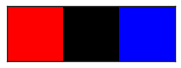

In [40]:
import matplotlib

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        # [0.1, 0.1, 0.1],          # black
        # [0.4, 0.4, 0.4],          # very dark gray
        # [0.7, 0.7, 0.7],          # dark gray
        # [0.9, 0.9, 0.9],          # light gray
        'red',
        'black',
        'blue'
    ])
        
        
def set_size(fig, w=6, h=3):
    fig.set_size_inches(w, h)
    plt.tight_layout()

    
sns.palplot(get_colors())

set_style()
sns.set_palette(np.array(get_colors()))

# Get the OC spatial data

In [41]:
# read in the data
oc_directory = os.path.join("..", "data", "oc")
oc_deduped = pd.read_csv(os.path.join(oc_directory, "visits_deduped.csv"))
oc_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n1.csv"))

# location weights based on number of visits
oc_locs = oc_deduped.groupby('location_id')['event_id'].count()
oc_wt_e = pd.DataFrame(oc_locs).reset_index().rename(columns={'event_id': 'weight'})
oc_wt_e['weight'] = 1 / oc_wt_e['weight']

# location weights based on number of unique users at location
oc_locs_users = oc_deduped.groupby(['location_id'])['old_uid'].nunique()
oc_wt_u = pd.DataFrame(oc_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
oc_wt_u['weight'] = 1 / oc_wt_u['weight']

# merge weights in to the point pattern data
oc_deduped = pd.merge(oc_deduped, oc_wt_e, on='location_id')
oc_deduped = pd.merge(oc_deduped, oc_wt_u, on='location_id', suffixes=('_event', '_user'))

# merge weights in to the point pattern data
oc_mpp = pd.merge(oc_mpp, oc_wt_e, on='location_id')
oc_mpp = pd.merge(oc_mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))


# get counts of events in A & B
cts = oc_mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

# read in the results
oc_rslt_directory = os.path.join("..", "data", "DFRWS_USA", "oc")
slr = pd.read_csv(os.path.join(oc_rslt_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(oc_rslt_directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(oc_rslt_directory, "lr.csv"))

# add labels 
lr["same-src"] = (lr.a == lr.b).astype(bool)

slr["same-src"] = (slr.a == slr.b).astype(bool)
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr

cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr


# merge & bin counts
splits = [1, 2, 20, float("inf")]

lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

oc_lr = lr
oc_slr = slr
oc_cmp = cmp

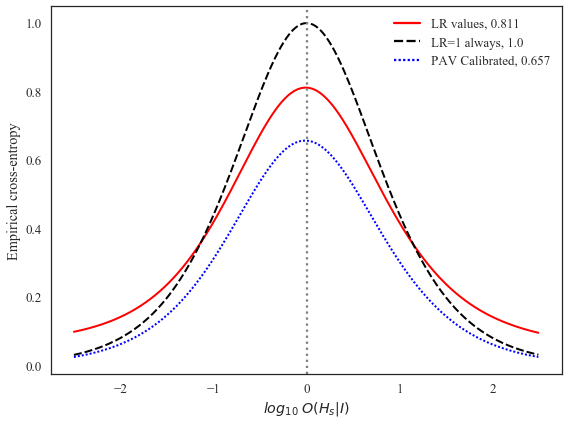

In [42]:
f, ax = plot_ece(oc_lr, 'lr_alpha_vary', rng=[-2.5,2.5])
set_size(f, w=8, h=6)
# plt.savefig('./figs/ece_with_calibration.eps', dpi=500)

plt.show()

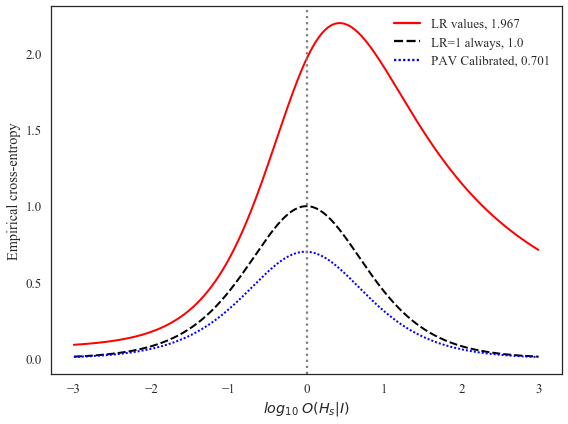

In [68]:
f, ax = plot_ece(oc_lr, 'lr_alpha_80')
set_size(f, w=8, h=6)
plt.show()

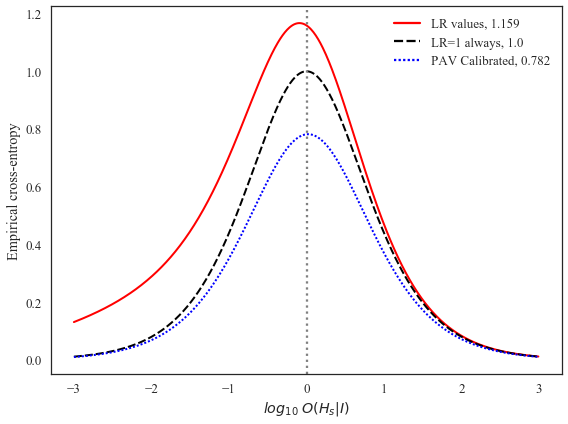

In [69]:
f, ax = plot_ece(oc_slr, 'emd')
set_size(f, w=8, h=6)
plt.show()

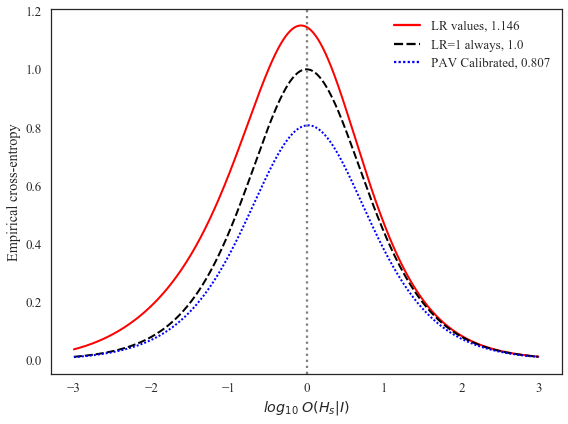

In [70]:
f, ax = plot_ece(oc_slr, 'ied_mn')
set_size(f, w=8, h=6)
plt.show()

# Get the NY spatial data

In [78]:
# read in the data
ny_directory = os.path.join("..", "data", "ny")
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
ny_mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n1.csv"))

# location weights based on number of visits
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at location
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_deduped = pd.merge(ny_deduped, ny_wt_e, on='location_id')
ny_deduped = pd.merge(ny_deduped, ny_wt_u, on='location_id', suffixes=('_event', '_user'))

# merge weights in to the point pattern data
ny_mpp = pd.merge(ny_mpp, ny_wt_e, on='location_id')
ny_mpp = pd.merge(ny_mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))

# get counts of events in A & B
cts = ny_mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

# read in the results
ny_rslt_directory = os.path.join("..", "data", "DFRWS_USA", "ny")
slr = pd.read_csv(os.path.join(ny_rslt_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(ny_rslt_directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(ny_rslt_directory, "lr.csv"))

# add labels 
lr["same-src"] = (lr.a == lr.b).astype(bool)

slr["same-src"] = (slr.a == slr.b).astype(bool)
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr

cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr


# merge & bin counts
splits = [1, 2, 20, float("inf")]

lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

ny_lr = lr
ny_slr = slr
ny_cmp = cmp

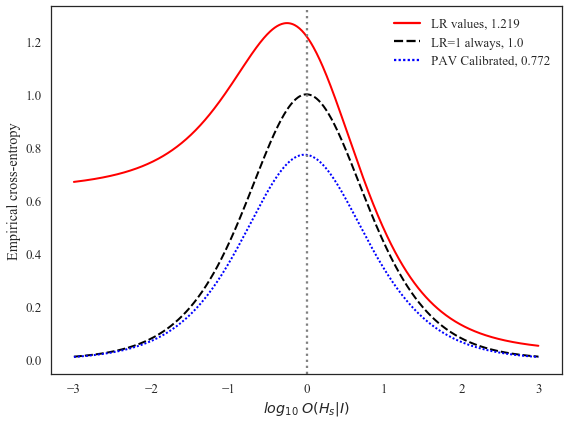

In [79]:
f, ax = plot_ece(ny_lr, 'lr_alpha_vary')
set_size(f, w=8, h=6)
plt.show()

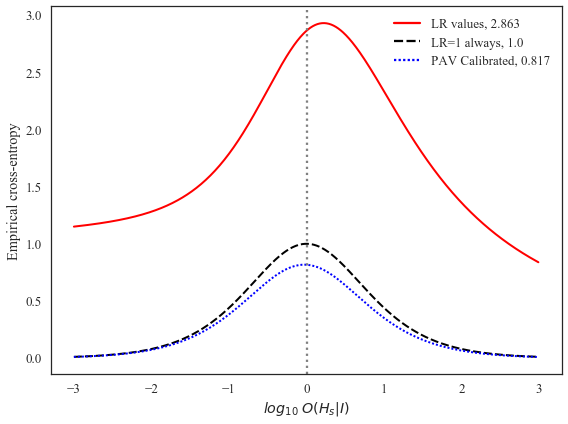

In [80]:
f, ax = plot_ece(ny_lr, 'lr_alpha_80')
set_size(f, w=8, h=6)
plt.show()

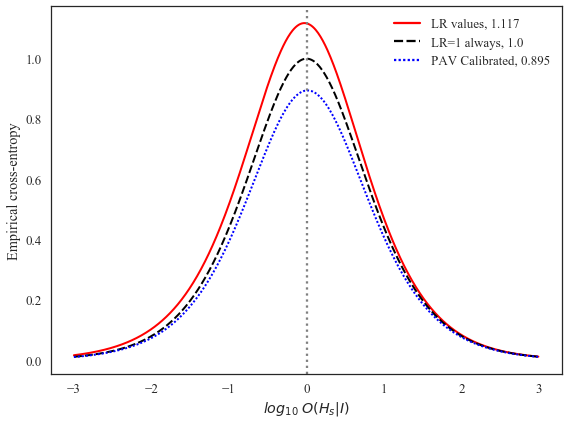

In [81]:
f, ax = plot_ece(ny_slr, 'emd')
set_size(f, w=8, h=6)
plt.show()

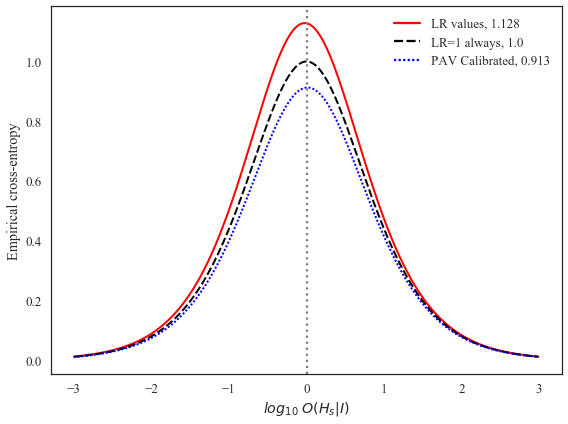

In [82]:
f, ax = plot_ece(ny_slr, 'ied_mn')
set_size(f, w=8, h=6)
plt.show()

# SoCal Gowalla Data

In [85]:
# read in the data
gowalla_directory = os.path.join("..", "data", "gowalla")
gowalla_visits = pd.read_csv(os.path.join(gowalla_directory, "visits.csv"))
gowalla_mpp = pd.read_csv(os.path.join(gowalla_directory, "mpp_octA_septB.csv"))

# location weights based on number of visits
gowalla_locs = gowalla_visits.groupby('location_id')['lat'].count()
gowalla_wt_e = pd.DataFrame(gowalla_locs).reset_index().rename(columns={'lat': 'weight'})
gowalla_wt_e['weight'] = 1 / gowalla_wt_e['weight']

# location weights based on number of unique users at location
gowalla_locs_users = gowalla_visits.groupby(['location_id'])['lat'].nunique()
gowalla_wt_u = pd.DataFrame(gowalla_locs_users).reset_index().rename(columns={'lat': 'weight'})
gowalla_wt_u['weight'] = 1 / gowalla_wt_u['weight']

# merge weights in to the point pattern data
gowalla_visits = pd.merge(gowalla_visits, gowalla_wt_e, on='location_id')
gowalla_visits = pd.merge(gowalla_visits, gowalla_wt_u, on='location_id', suffixes=('_event', '_user'))

# merge weights in to the point pattern data
gowalla_mpp = pd.merge(gowalla_mpp, gowalla_wt_e, on='location_id')
gowalla_mpp = pd.merge(gowalla_mpp, gowalla_wt_u, on='location_id', suffixes=('_event', '_user'))

# get counts of events in A & B
cts = gowalla_mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"location_id": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"location_id": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

# read in the results
slr = pd.read_csv(os.path.join(gowalla_directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(gowalla_directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(gowalla_directory, "lr.csv"))

# add labels 
lr["same-src"] = (lr.a == lr.b).astype(bool)

slr["same-src"] = (slr.a == slr.b).astype(bool)
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr

cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr


# merge & bin counts
splits = [1, 5, 15, float("inf")]

lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

gowalla_lr = lr
gowalla_slr = slr
gowalla_cmp = cmp

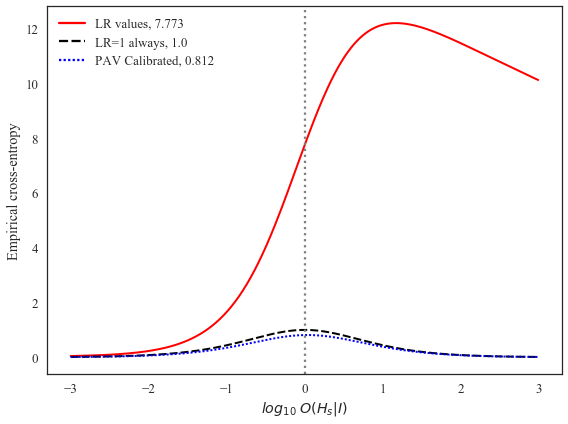

In [87]:
f, ax = plot_ece(gowalla_lr, 'lr_alpha_80')
set_size(f, w=8, h=6)
plt.show()

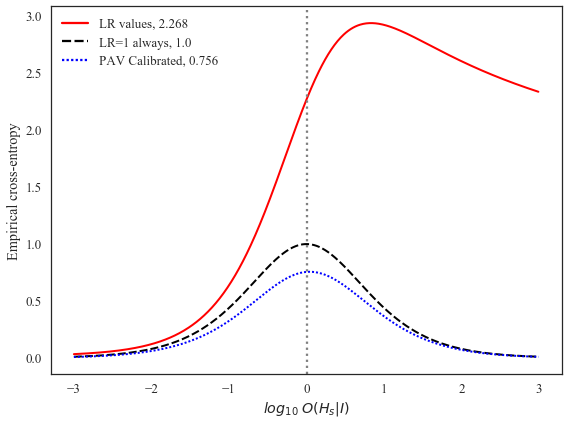

In [88]:
f, ax = plot_ece(gowalla_lr, 'lr_alpha_step')
set_size(f, w=8, h=6)
plt.show()

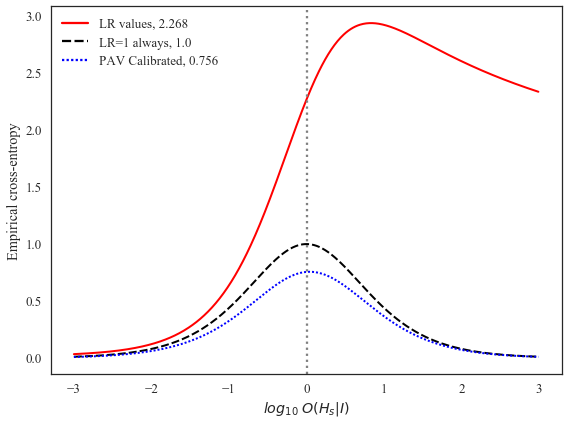

In [89]:
f, ax = plot_ece(gowalla_lr, 'lr_alpha_func')
set_size(f, w=8, h=6)
plt.show()

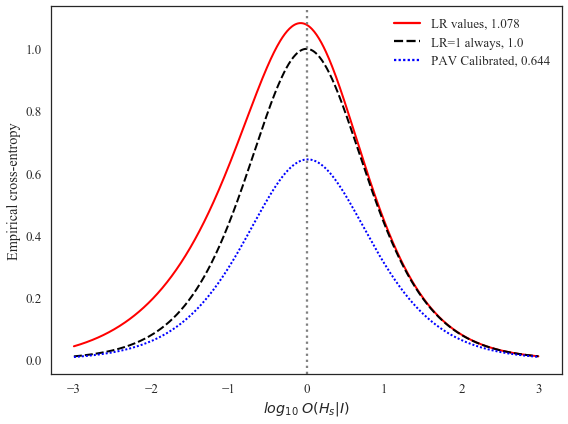

In [90]:
f, ax = plot_ece(gowalla_slr, 'emd')
set_size(f, w=8, h=6)
plt.show()

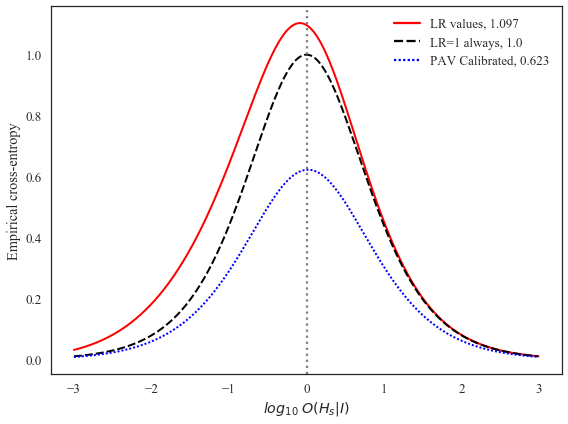

In [91]:
f, ax = plot_ece(gowalla_slr, 'ied_mn')
set_size(f, w=8, h=6)
plt.show()

# Manual Implementation of PAV Alg

In [14]:
# def PAV(y):
#     """
#     Pool Adjacent Violators (PAV) Algorithm for isotonic regression
    
#     Input: np.array of binary values 
    
#     Output: vector of monotonic posterior probabilities
#     """
#     n = len(y)
#     index = np.zeros(n, dtype='int8')
#     length = np.zeros(n)
#     yhat = np.zeros(n)
    
#     ci = 0  # current interval 
#     index[ci] = 0
#     length[ci] = 1
#     yhat[ci] = y[0]
#     for j in range(1,n):
#         ci += 1
#         index[ci] = j
#         length[ci] = 1
#         yhat[ci] = y[j]
#         while ci >= 2 and yhat[np.max([ci-1, 0])] >= yhat[ci]:
#             # pool adjacent violators
#             nw = length[ci-1] + length[ci]
#             yhat[ci-1] = yhat[ci-1] + (length[ci]/nw) * (yhat[ci] - yhat[ci-1])
#             length[ci-1] = nw
#             ci -= 1
#     # define yhat for each input y
#     while n >= 1:
#         for j in range(index[ci], n):
#             yhat[j] = yhat[ci]
#         n = index[ci] 
#         ci -= 1

#     return yhat


# def calibrate_lr(data, score_col, laplace=True):
#     same = np.array(data[score_col].loc[data.a == data.b])
#     n_s = len(same)
#     diff = np.array(data[score_col].loc[data.a != data.b])
#     n_d = len(diff)

#     scores = np.concatenate([diff, same])
#     p_ideal = np.concatenate([np.zeros(n_d), np.ones(n_s)])  # non-monotic probs

#     perturb = np.argsort(scores)  # sort in ascending order of score
#     scores = scores[perturb]  
#     p_ideal = p_ideal[perturb]

#     if laplace: # apply Laplace's Rule of Succession to prevent infs
#         p_ideal = np.concatenate([[1,0], p_ideal, [1,0]])
    
#     p_opt = PAV(p_ideal)  # Pool Adjacent Violators to get optimum posterior probs

#     if laplace:  # remove the leading & trailing obs
#         p_opt = p_opt[2:-2]
    
#     return p_opt[perturb]
#     post_log_odds = np.log(p_opt) - np.log(1-p_opt)
#     prior_log_odds = np.log(n_s/n_d)
#     log_lr = post_log_odds - prior_log_odds

#     return log_lr[perturb]  # undo the sort


# # test the PAV implementation
# p = np.array([0,0,1,0,1,0,0,1,0,1,1])
# assert(np.array_equal(PAV(p), [0,0,0.4,0.4,0.4,0.4,0.4,0.5,0.5,1,1]))

# # something is fucked... all values are the same
# calibrate_lr(oc_lr, 'lr_alpha_80')

# Student Web Browsing Data

In [15]:
directory = os.path.join("..", "..", "thesis", "data")
browsing = pd.read_csv(os.path.join(directory, "student_web_browsing_slr.csv"))
browsing['same-src'] = (browsing.a == browsing.b).astype(bool)
browsing.head()

,a,b,iet_mn,iet_md,s,m,same-src
0,2,2,3.025308e+15,1.876839e+13,3.158077e+17,4.521514e+16,True
1,4,4,3.045875e+14,9.084513e+04,5.096204e+16,4.521514e+16,True
2,10,10,8.817127e+14,3.142483e+03,7.919797e+14,3.416272e+09,True
3,11,11,6.629888e+16,8.273711e+06,7.623582e+01,2.666592e-01,True
4,13,13,5.729002e+15,1.793316e+07,6.271003e+01,3.419754e+00,True


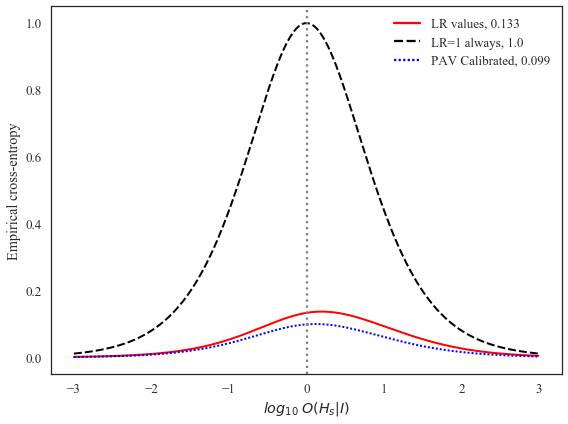

In [16]:
f, ax = plot_ece(browsing, 'iet_mn', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

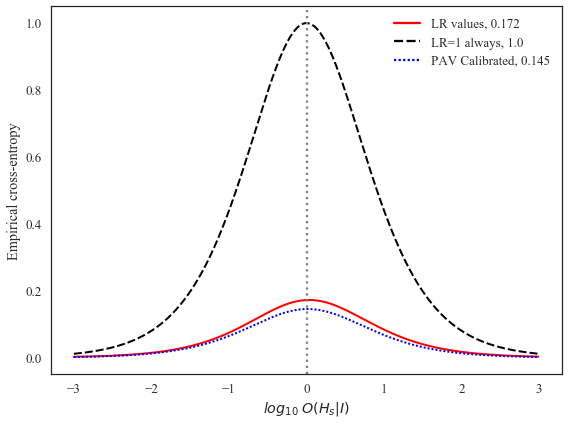

In [17]:
f, ax = plot_ece(browsing, 'iet_md', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

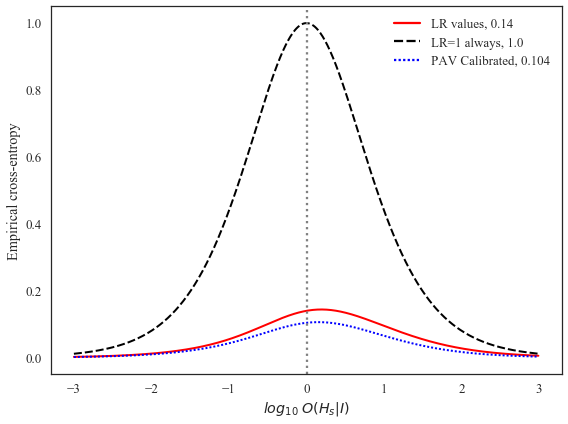

In [18]:
f, ax = plot_ece(browsing, 's', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

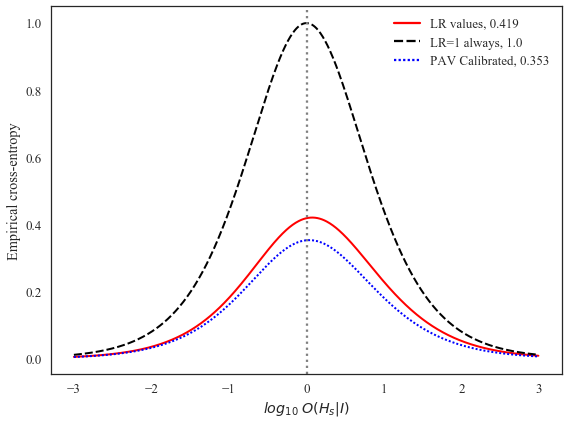

In [19]:
f, ax = plot_ece(browsing, 'm', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

# Temporal Simulation Data

In [20]:
simulation = pd.read_csv(os.path.join(directory, "simulation_results.csv"))
simulation['same-src'] = ~(simulation.indep.astype(bool))
simulation['a'] = 1
simulation['b'] = 1
simulation.b.loc[simulation['same-src'] == False] = 2
simulation.tail()

,r_mult,p,sigma,rate,iet_mn,iet_md,n_a,n_b,indep,slr_iet_mn,slr_iet_md,cmp_iet_mn,cmp_iet_md,snr,same-src,a,b
1199080,10,0.95,600,2110.752172,0.000231,0.000162,14770,14208,1,1.033195,1.031132,0.361636,0.364036,0.073,False,1,2
1199081,10,0.95,600,2271.032859,0.000215,0.000147,16008,14869,1,1.045193,1.046150,0.325533,0.314831,0.073,False,1,2
1199082,10,0.95,600,1994.465877,0.000253,0.000178,13849,13386,1,1.013153,1.009723,0.419142,0.440444,0.073,False,1,2
1199083,10,0.95,600,3233.492330,0.000153,0.000106,22823,21447,1,1.068596,1.066913,0.146315,0.156416,0.073,False,1,2
1199084,10,0.95,600,1212.883466,0.000392,0.000278,8637,8128,1,1.063401,1.041831,0.600060,0.612361,0.073,False,1,2


### Low SNR

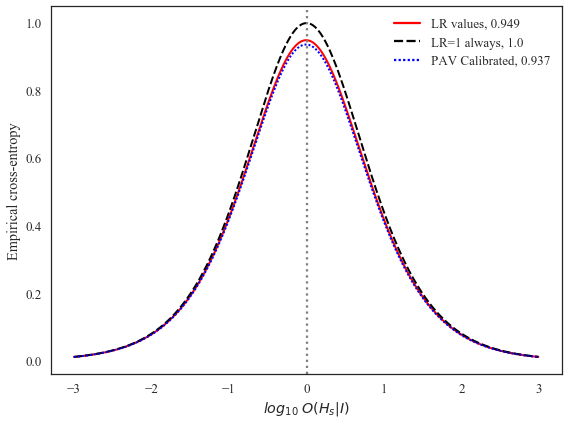

In [21]:
ind = (simulation.p == 0.20) & (simulation.snr == 0.073)

f, ax = plot_ece(simulation.loc[ind], 'slr_iet_mn', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

### Medium SNR

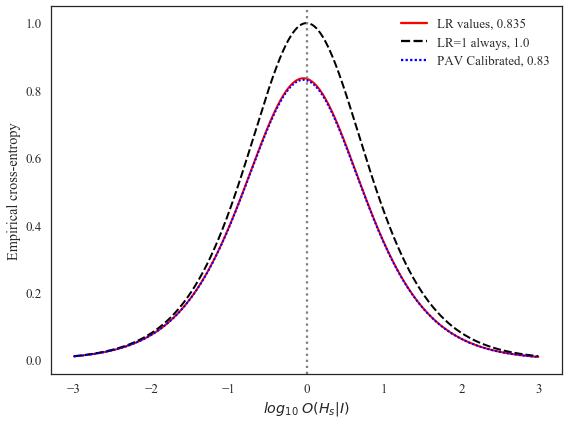

In [22]:
ind = (simulation.p == 0.20) & (simulation.snr == 0.73) & (simulation.r_mult == 1)

f, ax = plot_ece(simulation.loc[ind], 'slr_iet_mn', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

### High SNR

In [23]:
ind = (simulation.p == 0.20) & (simulation.snr == 3.65) & (simulation.r_mult == 1)
# simulation['slr_iet_mn'].loc[  # need if using snr==7.3
#     ind & (simulation['same-src'] == True) & (simulation['slr_iet_mn'] == 0)] = 1e-6

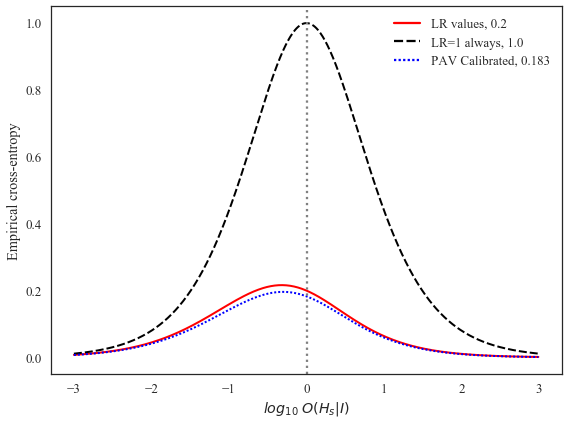

In [24]:
f, ax = plot_ece(simulation.loc[ind], 'slr_iet_mn', log_scale=False)
set_size(f, w=8, h=6)
plt.show()

# Logarithmic Scoring Func

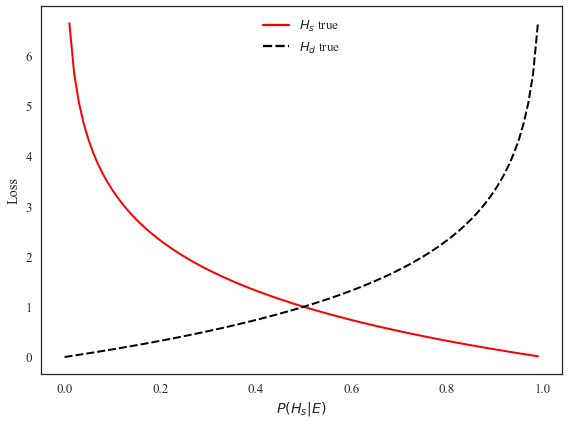

In [75]:
pr = np.arange(0, 1, 0.01)
h_s = - log2(pr)
h_d = - log2(1-pr)
dat = pd.DataFrame({'pr': pr, 
                    '$H_s$ true': h_s,
                    '$H_d$ true': h_d
                   })
dat = dat.melt('pr')

f, ax = plt.subplots()

ax = sns.lineplot(
    x='pr',
    y='value',
    style='variable',
    data=dat,
    hue='variable',
    lw=2
)

ax.set(ylabel="Loss")
ax.set(xlabel="$P(H_s | E)$")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center')

set_size(f, w=8, h=6)
plt.savefig('./figs/logarithmic_scoring_func_penalty.eps', dpi=500)

plt.show()

# Prior Entropy

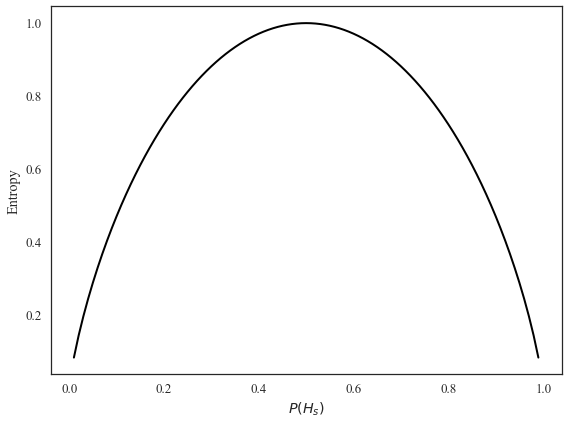

In [77]:
pr = np.arange(0, 1, 0.01)
entropy = -pr*log2(pr) - (1-pr)*log2(1-pr)
dat = pd.DataFrame({'pr': pr, 
                    'entropy': entropy
                   })

f, ax = plt.subplots()

ax = sns.lineplot(
    x='pr',
    y='entropy',
    color='black',
    data=dat,
    lw=2
)

ax.set(ylabel="Entropy")
ax.set(xlabel="$P(H_s)$")

set_size(f, w=8, h=6)
plt.savefig('./figs/prior_entropy.eps', dpi=500)

plt.show()